<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:13:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


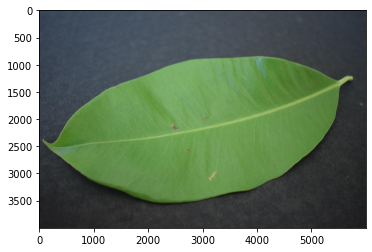

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

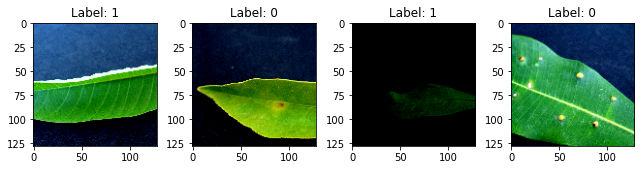

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[16:13:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:13:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2523799353954352 samples/sec                   batch loss = 1.205773949623108 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.2626560124365915 samples/sec                   batch loss = 0.48306822776794434 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2596174196907568 samples/sec                   batch loss = 0.5733562707901001 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2660223872617316 samples/sec                   batch loss = 1.2221918106079102 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.257714977882883 samples/sec                   batch loss = 0.8655109405517578 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2551684037698407 samples/sec                   batch loss = 0.3602276146411896 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2599908015922678 samples/sec                   batch loss = 0.5119214653968811 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2622725971121813 samples/sec                   batch loss = 0.5722048878669739 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2627608366885217 samples/sec                   batch loss = 0.7269545793533325 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2649862981060134 samples/sec                   batch loss = 0.29945969581604004 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2640376097768664 samples/sec                   batch loss = 0.6047061681747437 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2612008218259732 samples/sec                   batch loss = 0.654772162437439 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2567172872694237 samples/sec                   batch loss = 1.8530333042144775 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2686034554840249 samples/sec                   batch loss = 0.797539472579956 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2659960201286022 samples/sec                   batch loss = 0.5957832932472229 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.2645142539982013 samples/sec                   batch loss = 0.7064448595046997 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2671583623935623 samples/sec                   batch loss = 0.6777082085609436 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.2642443051903882 samples/sec                   batch loss = 1.3736743927001953 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2617139460499958 samples/sec                   batch loss = 0.6690918207168579 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.264802911308581 samples/sec                   batch loss = 0.44680067896842957 | accuracy = 0.585


Epoch[1] Batch[105] Speed: 1.2659562804378883 samples/sec                   batch loss = 0.9629884362220764 | accuracy = 0.5857142857142857


Epoch[1] Batch[110] Speed: 1.2648741426096513 samples/sec                   batch loss = 0.7121315002441406 | accuracy = 0.5840909090909091


Epoch[1] Batch[115] Speed: 1.2576193797273496 samples/sec                   batch loss = 0.4498642683029175 | accuracy = 0.5869565217391305


Epoch[1] Batch[120] Speed: 1.2626047945853411 samples/sec                   batch loss = 0.5576995015144348 | accuracy = 0.59375


Epoch[1] Batch[125] Speed: 1.2610734116877007 samples/sec                   batch loss = 1.0341640710830688 | accuracy = 0.588


Epoch[1] Batch[130] Speed: 1.2608883147062162 samples/sec                   batch loss = 0.6334922909736633 | accuracy = 0.5884615384615385


Epoch[1] Batch[135] Speed: 1.2594334116468577 samples/sec                   batch loss = 0.3050759732723236 | accuracy = 0.5944444444444444


Epoch[1] Batch[140] Speed: 1.2599504918001763 samples/sec                   batch loss = 0.49150872230529785 | accuracy = 0.6017857142857143


Epoch[1] Batch[145] Speed: 1.255344028823531 samples/sec                   batch loss = 0.2810823321342468 | accuracy = 0.6103448275862069


Epoch[1] Batch[150] Speed: 1.2560933820071676 samples/sec                   batch loss = 0.5224874019622803 | accuracy = 0.6116666666666667


Epoch[1] Batch[155] Speed: 1.2574637574110297 samples/sec                   batch loss = 0.8531067371368408 | accuracy = 0.614516129032258


Epoch[1] Batch[160] Speed: 1.2579798814288434 samples/sec                   batch loss = 0.4596507251262665 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.2608326919780375 samples/sec                   batch loss = 0.5800195932388306 | accuracy = 0.6181818181818182


Epoch[1] Batch[170] Speed: 1.2597966570051211 samples/sec                   batch loss = 0.5576109290122986 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2623927455902413 samples/sec                   batch loss = 0.4352255165576935 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2569792279308472 samples/sec                   batch loss = 1.235846757888794 | accuracy = 0.6236111111111111


Epoch[1] Batch[185] Speed: 1.259464422596259 samples/sec                   batch loss = 0.48578986525535583 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.260270107629753 samples/sec                   batch loss = 0.6084228754043579 | accuracy = 0.6302631578947369


Epoch[1] Batch[195] Speed: 1.2611486791484976 samples/sec                   batch loss = 0.9130548238754272 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2604465004935188 samples/sec                   batch loss = 0.5187080502510071 | accuracy = 0.63125


Epoch[1] Batch[205] Speed: 1.2608590339871424 samples/sec                   batch loss = 0.5052155256271362 | accuracy = 0.6317073170731707


Epoch[1] Batch[210] Speed: 1.2598307131314466 samples/sec                   batch loss = 0.3096635937690735 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.2601582189131864 samples/sec                   batch loss = 0.7830536961555481 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2592433138696169 samples/sec                   batch loss = 0.2138580083847046 | accuracy = 0.6375


Epoch[1] Batch[225] Speed: 1.2614839844274863 samples/sec                   batch loss = 0.8412764668464661 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.2610446910829798 samples/sec                   batch loss = 0.3561353087425232 | accuracy = 0.6413043478260869


Epoch[1] Batch[235] Speed: 1.2619699053726565 samples/sec                   batch loss = 0.2740286588668823 | accuracy = 0.6436170212765957


Epoch[1] Batch[240] Speed: 1.2591876471657084 samples/sec                   batch loss = 0.6345971822738647 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2604989639353328 samples/sec                   batch loss = 0.598008394241333 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2580507236041831 samples/sec                   batch loss = 1.5084829330444336 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2594202702722992 samples/sec                   batch loss = 0.5784456133842468 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2654368370957916 samples/sec                   batch loss = 0.46191325783729553 | accuracy = 0.6471153846153846


Epoch[1] Batch[265] Speed: 1.2601022820048113 samples/sec                   batch loss = 0.7688202261924744 | accuracy = 0.6490566037735849


Epoch[1] Batch[270] Speed: 1.2657678374623225 samples/sec                   batch loss = 0.550295889377594 | accuracy = 0.649074074074074


Epoch[1] Batch[275] Speed: 1.2655959668011831 samples/sec                   batch loss = 0.583320677280426 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2641377104972789 samples/sec                   batch loss = 0.36675214767456055 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2629551354458095 samples/sec                   batch loss = 0.1842065304517746 | accuracy = 0.65


Epoch[1] Batch[290] Speed: 1.262591491927142 samples/sec                   batch loss = 0.5223595499992371 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.266998456844898 samples/sec                   batch loss = 0.7828801274299622 | accuracy = 0.6567796610169492


Epoch[1] Batch[300] Speed: 1.2574785544841647 samples/sec                   batch loss = 0.628257691860199 | accuracy = 0.6558333333333334


Epoch[1] Batch[305] Speed: 1.2655525291074465 samples/sec                   batch loss = 0.8609400987625122 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2631203934663102 samples/sec                   batch loss = 0.24815036356449127 | accuracy = 0.660483870967742


Epoch[1] Batch[315] Speed: 1.2588535613571974 samples/sec                   batch loss = 0.4302089214324951 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.2629412549802432 samples/sec                   batch loss = 0.3936549127101898 | accuracy = 0.66328125


Epoch[1] Batch[325] Speed: 1.2615998085779863 samples/sec                   batch loss = 0.31794318556785583 | accuracy = 0.6646153846153846


Epoch[1] Batch[330] Speed: 1.2598815169417976 samples/sec                   batch loss = 0.5841858386993408 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2654324465614917 samples/sec                   batch loss = 0.5317338109016418 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.2656509603343442 samples/sec                   batch loss = 0.5739011168479919 | accuracy = 0.6676470588235294


Epoch[1] Batch[345] Speed: 1.2617832165965113 samples/sec                   batch loss = 1.661961317062378 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.2636111926627893 samples/sec                   batch loss = 1.0197508335113525 | accuracy = 0.6671428571428571


Epoch[1] Batch[355] Speed: 1.2623268273087354 samples/sec                   batch loss = 0.5626300573348999 | accuracy = 0.6661971830985915


Epoch[1] Batch[360] Speed: 1.2592060761746446 samples/sec                   batch loss = 0.5202642679214478 | accuracy = 0.6659722222222222


Epoch[1] Batch[365] Speed: 1.2653026532248814 samples/sec                   batch loss = 0.7518364191055298 | accuracy = 0.6664383561643835


Epoch[1] Batch[370] Speed: 1.269194532933801 samples/sec                   batch loss = 0.8450915217399597 | accuracy = 0.6655405405405406


Epoch[1] Batch[375] Speed: 1.2663085795094482 samples/sec                   batch loss = 0.5296989679336548 | accuracy = 0.6666666666666666


Epoch[1] Batch[380] Speed: 1.262612206187932 samples/sec                   batch loss = 0.4560811221599579 | accuracy = 0.6677631578947368


Epoch[1] Batch[385] Speed: 1.26109834185405 samples/sec                   batch loss = 0.45697110891342163 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.2595782685642758 samples/sec                   batch loss = 0.22576682269573212 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2603729264532997 samples/sec                   batch loss = 0.2468140572309494 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.262338984629639 samples/sec                   batch loss = 0.9969562888145447 | accuracy = 0.671875


Epoch[1] Batch[405] Speed: 1.2628306975083332 samples/sec                   batch loss = 0.6452388167381287 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2644356301118562 samples/sec                   batch loss = 0.393357515335083 | accuracy = 0.6737804878048781


Epoch[1] Batch[415] Speed: 1.2661127699001544 samples/sec                   batch loss = 0.5942662954330444 | accuracy = 0.6740963855421687


Epoch[1] Batch[420] Speed: 1.2690393925874894 samples/sec                   batch loss = 0.5420985221862793 | accuracy = 0.6732142857142858


Epoch[1] Batch[425] Speed: 1.259660167178185 samples/sec                   batch loss = 1.3722496032714844 | accuracy = 0.6735294117647059


Epoch[1] Batch[430] Speed: 1.265008044840893 samples/sec                   batch loss = 1.289922833442688 | accuracy = 0.6726744186046512


Epoch[1] Batch[435] Speed: 1.2587212421123677 samples/sec                   batch loss = 0.5819128751754761 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.2637940436195794 samples/sec                   batch loss = 0.8907920122146606 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.267276666796336 samples/sec                   batch loss = 0.8837467432022095 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.26404170492823 samples/sec                   batch loss = 0.5989317297935486 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.2676364057284912 samples/sec                   batch loss = 0.2096276581287384 | accuracy = 0.6774725274725275


Epoch[1] Batch[460] Speed: 1.262050406443152 samples/sec                   batch loss = 0.38157400488853455 | accuracy = 0.6793478260869565


Epoch[1] Batch[465] Speed: 1.2693864948004399 samples/sec                   batch loss = 0.9398588538169861 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.2667905730007267 samples/sec                   batch loss = 0.45558294653892517 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.259176779028691 samples/sec                   batch loss = 0.24373047053813934 | accuracy = 0.6810526315789474


Epoch[1] Batch[480] Speed: 1.2689785372406406 samples/sec                   batch loss = 0.8621444702148438 | accuracy = 0.6802083333333333


Epoch[1] Batch[485] Speed: 1.2617790411700784 samples/sec                   batch loss = 0.4746582806110382 | accuracy = 0.6793814432989691


Epoch[1] Batch[490] Speed: 1.2714514215109198 samples/sec                   batch loss = 0.3926669657230377 | accuracy = 0.6790816326530612


Epoch[1] Batch[495] Speed: 1.2665234759412707 samples/sec                   batch loss = 0.2906969487667084 | accuracy = 0.6792929292929293


Epoch[1] Batch[500] Speed: 1.2636722957369366 samples/sec                   batch loss = 0.6155004501342773 | accuracy = 0.6795


Epoch[1] Batch[505] Speed: 1.2659362204839077 samples/sec                   batch loss = 0.4476078152656555 | accuracy = 0.6787128712871288


Epoch[1] Batch[510] Speed: 1.2661473594824326 samples/sec                   batch loss = 0.2637507915496826 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.2649929746556035 samples/sec                   batch loss = 0.2798140347003937 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2579426240988623 samples/sec                   batch loss = 0.570410430431366 | accuracy = 0.6826923076923077


Epoch[1] Batch[525] Speed: 1.261291181074185 samples/sec                   batch loss = 0.7548576593399048 | accuracy = 0.6819047619047619


Epoch[1] Batch[530] Speed: 1.2662868836120194 samples/sec                   batch loss = 0.8974315524101257 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.2671656361369807 samples/sec                   batch loss = 0.5594099164009094 | accuracy = 0.6827102803738317


Epoch[1] Batch[540] Speed: 1.258315674239864 samples/sec                   batch loss = 0.33957502245903015 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.2643611132233348 samples/sec                   batch loss = 0.6340132355690002 | accuracy = 0.681651376146789


Epoch[1] Batch[550] Speed: 1.2637701491044273 samples/sec                   batch loss = 0.45424023270606995 | accuracy = 0.6813636363636364


Epoch[1] Batch[555] Speed: 1.263050690765477 samples/sec                   batch loss = 0.8668147325515747 | accuracy = 0.6792792792792792


Epoch[1] Batch[560] Speed: 1.266748870515046 samples/sec                   batch loss = 0.5349229574203491 | accuracy = 0.6785714285714286


Epoch[1] Batch[565] Speed: 1.2628614957531306 samples/sec                   batch loss = 0.3366009593009949 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.257147541452852 samples/sec                   batch loss = 0.39081376791000366 | accuracy = 0.6798245614035088


Epoch[1] Batch[575] Speed: 1.259447498748601 samples/sec                   batch loss = 0.6325749754905701 | accuracy = 0.6795652173913044


Epoch[1] Batch[580] Speed: 1.2687710586286136 samples/sec                   batch loss = 0.6719054579734802 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2695199132043051 samples/sec                   batch loss = 0.31654760241508484 | accuracy = 0.6803418803418804


Epoch[1] Batch[590] Speed: 1.2634325809591407 samples/sec                   batch loss = 1.0273879766464233 | accuracy = 0.6800847457627118


Epoch[1] Batch[595] Speed: 1.2697823172922416 samples/sec                   batch loss = 0.4397496283054352 | accuracy = 0.6798319327731093


Epoch[1] Batch[600] Speed: 1.2642026749180506 samples/sec                   batch loss = 0.38500162959098816 | accuracy = 0.6808333333333333


Epoch[1] Batch[605] Speed: 1.2674483240238235 samples/sec                   batch loss = 0.5794318914413452 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2621570292108442 samples/sec                   batch loss = 0.7445840239524841 | accuracy = 0.6786885245901639


Epoch[1] Batch[615] Speed: 1.2631112641618232 samples/sec                   batch loss = 1.0308247804641724 | accuracy = 0.6788617886178862


Epoch[1] Batch[620] Speed: 1.2616851013805863 samples/sec                   batch loss = 0.24172066152095795 | accuracy = 0.680241935483871


Epoch[1] Batch[625] Speed: 1.2623282519826657 samples/sec                   batch loss = 0.7356554865837097 | accuracy = 0.6796


Epoch[1] Batch[630] Speed: 1.2607820009210196 samples/sec                   batch loss = 0.4438621401786804 | accuracy = 0.6793650793650794


Epoch[1] Batch[635] Speed: 1.260192862534386 samples/sec                   batch loss = 0.8836374282836914 | accuracy = 0.6791338582677166


Epoch[1] Batch[640] Speed: 1.2616273211252516 samples/sec                   batch loss = 0.7355160713195801 | accuracy = 0.67890625


Epoch[1] Batch[645] Speed: 1.2603102485258948 samples/sec                   batch loss = 0.8918739557266235 | accuracy = 0.6782945736434108


Epoch[1] Batch[650] Speed: 1.262539139187711 samples/sec                   batch loss = 0.30932554602622986 | accuracy = 0.6792307692307692


Epoch[1] Batch[655] Speed: 1.2687891935068052 samples/sec                   batch loss = 0.5517750978469849 | accuracy = 0.6793893129770993


Epoch[1] Batch[660] Speed: 1.2595201137750103 samples/sec                   batch loss = 0.5097754597663879 | accuracy = 0.6791666666666667


Epoch[1] Batch[665] Speed: 1.256273405063622 samples/sec                   batch loss = 0.714191734790802 | accuracy = 0.6796992481203008


Epoch[1] Batch[670] Speed: 1.2661411485066263 samples/sec                   batch loss = 0.5109827518463135 | accuracy = 0.6809701492537313


Epoch[1] Batch[675] Speed: 1.2638533554245557 samples/sec                   batch loss = 0.6857640147209167 | accuracy = 0.6811111111111111


Epoch[1] Batch[680] Speed: 1.262381537096963 samples/sec                   batch loss = 0.656819224357605 | accuracy = 0.6808823529411765


Epoch[1] Batch[685] Speed: 1.2618880857997636 samples/sec                   batch loss = 0.34026968479156494 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.2607089561183198 samples/sec                   batch loss = 0.35473719239234924 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2597215508348956 samples/sec                   batch loss = 0.6978499889373779 | accuracy = 0.6823741007194245


Epoch[1] Batch[700] Speed: 1.2598518099332596 samples/sec                   batch loss = 1.0398796796798706 | accuracy = 0.6814285714285714


Epoch[1] Batch[705] Speed: 1.2595543440739545 samples/sec                   batch loss = 0.8624709844589233 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.2616160313486153 samples/sec                   batch loss = 0.43463870882987976 | accuracy = 0.6816901408450704


Epoch[1] Batch[715] Speed: 1.258805484980889 samples/sec                   batch loss = 0.3664362132549286 | accuracy = 0.6828671328671329


Epoch[1] Batch[720] Speed: 1.258249237387933 samples/sec                   batch loss = 0.692115068435669 | accuracy = 0.6822916666666666


Epoch[1] Batch[725] Speed: 1.2608214164184686 samples/sec                   batch loss = 0.7185308933258057 | accuracy = 0.6820689655172414


Epoch[1] Batch[730] Speed: 1.2616315904211683 samples/sec                   batch loss = 0.34706366062164307 | accuracy = 0.6815068493150684


Epoch[1] Batch[735] Speed: 1.2547175448566779 samples/sec                   batch loss = 0.6543543934822083 | accuracy = 0.682312925170068


Epoch[1] Batch[740] Speed: 1.2542880143733262 samples/sec                   batch loss = 0.6216548085212708 | accuracy = 0.6820945945945946


Epoch[1] Batch[745] Speed: 1.2565827814648898 samples/sec                   batch loss = 0.3354599177837372 | accuracy = 0.6828859060402684


Epoch[1] Batch[750] Speed: 1.2590774623983312 samples/sec                   batch loss = 0.3350566625595093 | accuracy = 0.6826666666666666


Epoch[1] Batch[755] Speed: 1.25693129460908 samples/sec                   batch loss = 0.6435873508453369 | accuracy = 0.6827814569536423


Epoch[1] Batch[760] Speed: 1.2572310085212892 samples/sec                   batch loss = 0.17775429785251617 | accuracy = 0.6835526315789474


Epoch[1] Batch[765] Speed: 1.258761189959301 samples/sec                   batch loss = 0.40483489632606506 | accuracy = 0.6839869281045752


Epoch[1] Batch[770] Speed: 1.2533824529612227 samples/sec                   batch loss = 0.7032801508903503 | accuracy = 0.6840909090909091


Epoch[1] Batch[775] Speed: 1.2539054462682238 samples/sec                   batch loss = 0.15453916788101196 | accuracy = 0.6848387096774193


Epoch[1] Batch[780] Speed: 1.2551833346837398 samples/sec                   batch loss = 0.49547865986824036 | accuracy = 0.6849358974358974


Epoch[1] Batch[785] Speed: 1.2577666484192767 samples/sec                   batch loss = 0.2292853742837906 | accuracy = 0.6859872611464968


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 652.2188467979431
[Epoch 1] validation: validation accuracy=0.7088888888888889


Epoch[2] Batch[5] Speed: 1.2585565666520786 samples/sec                   batch loss = 0.32539674639701843 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.262091420371309 samples/sec                   batch loss = 0.8792092800140381 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2602792905808913 samples/sec                   batch loss = 0.22835499048233032 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.259740468421896 samples/sec                   batch loss = 0.44527941942214966 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2607539567791723 samples/sec                   batch loss = 0.35122883319854736 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2594980825501516 samples/sec                   batch loss = 0.4348428249359131 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.2591080778432027 samples/sec                   batch loss = 0.3596676290035248 | accuracy = 0.6928571428571428


Epoch[2] Batch[40] Speed: 1.2620557229130913 samples/sec                   batch loss = 0.7018243670463562 | accuracy = 0.69375


Epoch[2] Batch[45] Speed: 1.2626985862804827 samples/sec                   batch loss = 0.33256134390830994 | accuracy = 0.6777777777777778


Epoch[2] Batch[50] Speed: 1.2617813186719797 samples/sec                   batch loss = 0.3072572648525238 | accuracy = 0.69


Epoch[2] Batch[55] Speed: 1.262605744785939 samples/sec                   batch loss = 0.5478028059005737 | accuracy = 0.6863636363636364


Epoch[2] Batch[60] Speed: 1.2608111833120859 samples/sec                   batch loss = 0.3955475986003876 | accuracy = 0.7


Epoch[2] Batch[65] Speed: 1.2576061819127122 samples/sec                   batch loss = 0.4339442253112793 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2614523997136824 samples/sec                   batch loss = 0.3952065408229828 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.262717688424715 samples/sec                   batch loss = 0.09984830766916275 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.261965254091631 samples/sec                   batch loss = 0.5155516266822815 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2588881332805983 samples/sec                   batch loss = 0.3380722105503082 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2601684414229768 samples/sec                   batch loss = 0.6432129740715027 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2614571420622909 samples/sec                   batch loss = 0.5664677023887634 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2591843394519733 samples/sec                   batch loss = 0.21788907051086426 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.257057963285119 samples/sec                   batch loss = 0.17539064586162567 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2600408612388947 samples/sec                   batch loss = 0.516917884349823 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2556830207975016 samples/sec                   batch loss = 1.0383929014205933 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.262630545527341 samples/sec                   batch loss = 0.4170179069042206 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.2622384088402046 samples/sec                   batch loss = 0.5937245488166809 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2579799757539984 samples/sec                   batch loss = 0.5481164455413818 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2590809585312388 samples/sec                   batch loss = 0.4899978041648865 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2618934009022154 samples/sec                   batch loss = 0.09127332270145416 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2630893924066395 samples/sec                   batch loss = 0.539530336856842 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.26089409520308 samples/sec                   batch loss = 0.30706068873405457 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2623513321483721 samples/sec                   batch loss = 0.5896617770195007 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.2611833772502947 samples/sec                   batch loss = 0.49996110796928406 | accuracy = 0.765625


Epoch[2] Batch[165] Speed: 1.2602127408819783 samples/sec                   batch loss = 0.07384248077869415 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.2576307866331693 samples/sec                   batch loss = 0.7755186557769775 | accuracy = 0.7691176470588236


Epoch[2] Batch[175] Speed: 1.2595051740620198 samples/sec                   batch loss = 1.2484145164489746 | accuracy = 0.7728571428571429


Epoch[2] Batch[180] Speed: 1.260718903356248 samples/sec                   batch loss = 0.602996826171875 | accuracy = 0.7680555555555556


Epoch[2] Batch[185] Speed: 1.2628108315363393 samples/sec                   batch loss = 0.46051645278930664 | accuracy = 0.772972972972973


Epoch[2] Batch[190] Speed: 1.2618143433734916 samples/sec                   batch loss = 0.4581250250339508 | accuracy = 0.7723684210526316


Epoch[2] Batch[195] Speed: 1.2596210133943657 samples/sec                   batch loss = 0.19858318567276 | accuracy = 0.7705128205128206


Epoch[2] Batch[200] Speed: 1.25989930397411 samples/sec                   batch loss = 0.4019119143486023 | accuracy = 0.7675


Epoch[2] Batch[205] Speed: 1.2643954165822906 samples/sec                   batch loss = 0.9972344636917114 | accuracy = 0.7658536585365854


Epoch[2] Batch[210] Speed: 1.264891498707116 samples/sec                   batch loss = 0.3510761559009552 | accuracy = 0.7678571428571429


Epoch[2] Batch[215] Speed: 1.2665818011668075 samples/sec                   batch loss = 0.5295965075492859 | accuracy = 0.7686046511627908


Epoch[2] Batch[220] Speed: 1.2597495490654755 samples/sec                   batch loss = 0.3042208254337311 | accuracy = 0.7715909090909091


Epoch[2] Batch[225] Speed: 1.2665759684025184 samples/sec                   batch loss = 2.000197410583496 | accuracy = 0.7688888888888888


Epoch[2] Batch[230] Speed: 1.2636449794578426 samples/sec                   batch loss = 0.3565790355205536 | accuracy = 0.7684782608695652


Epoch[2] Batch[235] Speed: 1.2623091616191628 samples/sec                   batch loss = 0.6535685062408447 | accuracy = 0.7702127659574468


Epoch[2] Batch[240] Speed: 1.2627302334308588 samples/sec                   batch loss = 0.3179536759853363 | accuracy = 0.7729166666666667


Epoch[2] Batch[245] Speed: 1.2594241464765668 samples/sec                   batch loss = 0.37312987446784973 | accuracy = 0.7755102040816326


Epoch[2] Batch[250] Speed: 1.2577859788169587 samples/sec                   batch loss = 1.1020535230636597 | accuracy = 0.773


Epoch[2] Batch[255] Speed: 1.260407297812297 samples/sec                   batch loss = 0.09974732249975204 | accuracy = 0.7745098039215687


Epoch[2] Batch[260] Speed: 1.2616947793792228 samples/sec                   batch loss = 0.7361389398574829 | accuracy = 0.775


Epoch[2] Batch[265] Speed: 1.2539763926305973 samples/sec                   batch loss = 0.7389695644378662 | accuracy = 0.7764150943396226


Epoch[2] Batch[270] Speed: 1.2622823790974087 samples/sec                   batch loss = 0.9394017457962036 | accuracy = 0.7722222222222223


Epoch[2] Batch[275] Speed: 1.2525279431750687 samples/sec                   batch loss = 0.2566264271736145 | accuracy = 0.7745454545454545


Epoch[2] Batch[280] Speed: 1.2535887691488878 samples/sec                   batch loss = 0.6172201037406921 | accuracy = 0.7723214285714286


Epoch[2] Batch[285] Speed: 1.2562275949298087 samples/sec                   batch loss = 0.36371946334838867 | accuracy = 0.7710526315789473


Epoch[2] Batch[290] Speed: 1.2621475340217618 samples/sec                   batch loss = 0.2660978138446808 | accuracy = 0.771551724137931


Epoch[2] Batch[295] Speed: 1.2573942064080037 samples/sec                   batch loss = 0.41602998971939087 | accuracy = 0.7694915254237288


Epoch[2] Batch[300] Speed: 1.2630772206274712 samples/sec                   batch loss = 0.4980633556842804 | accuracy = 0.7691666666666667


Epoch[2] Batch[305] Speed: 1.2559981242246032 samples/sec                   batch loss = 0.5105684995651245 | accuracy = 0.7680327868852459


Epoch[2] Batch[310] Speed: 1.2569901523428175 samples/sec                   batch loss = 0.05680112540721893 | accuracy = 0.7693548387096775


Epoch[2] Batch[315] Speed: 1.2571940781578437 samples/sec                   batch loss = 1.248001217842102 | accuracy = 0.7698412698412699


Epoch[2] Batch[320] Speed: 1.2593734740792868 samples/sec                   batch loss = 0.16566947102546692 | accuracy = 0.76796875


Epoch[2] Batch[325] Speed: 1.2618909331705088 samples/sec                   batch loss = 0.17224107682704926 | accuracy = 0.7684615384615384


Epoch[2] Batch[330] Speed: 1.256714745605244 samples/sec                   batch loss = 0.628352165222168 | accuracy = 0.7681818181818182


Epoch[2] Batch[335] Speed: 1.2563397275012722 samples/sec                   batch loss = 0.5690970420837402 | accuracy = 0.7664179104477612


Epoch[2] Batch[340] Speed: 1.259721456248388 samples/sec                   batch loss = 0.37356674671173096 | accuracy = 0.7676470588235295


Epoch[2] Batch[345] Speed: 1.2555821872623174 samples/sec                   batch loss = 0.39504483342170715 | accuracy = 0.7695652173913043


Epoch[2] Batch[350] Speed: 1.2569246087191701 samples/sec                   batch loss = 0.1392723172903061 | accuracy = 0.77


Epoch[2] Batch[355] Speed: 1.2576208880666604 samples/sec                   batch loss = 0.2777867019176483 | accuracy = 0.7690140845070422


Epoch[2] Batch[360] Speed: 1.254967950743834 samples/sec                   batch loss = 0.7006102800369263 | accuracy = 0.76875


Epoch[2] Batch[365] Speed: 1.253666611918624 samples/sec                   batch loss = 0.4684566557407379 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.2586453198607428 samples/sec                   batch loss = 0.3289509117603302 | accuracy = 0.7695945945945946


Epoch[2] Batch[375] Speed: 1.2556418584607407 samples/sec                   batch loss = 0.29797232151031494 | accuracy = 0.77


Epoch[2] Batch[380] Speed: 1.257601939816835 samples/sec                   batch loss = 0.44342154264450073 | accuracy = 0.7703947368421052


Epoch[2] Batch[385] Speed: 1.2662102370990973 samples/sec                   batch loss = 0.1718732714653015 | accuracy = 0.7727272727272727


Epoch[2] Batch[390] Speed: 1.2550616440011153 samples/sec                   batch loss = 0.18416225910186768 | accuracy = 0.7730769230769231


Epoch[2] Batch[395] Speed: 1.2654567857766208 samples/sec                   batch loss = 1.048130750656128 | accuracy = 0.7734177215189874


Epoch[2] Batch[400] Speed: 1.2586433369395922 samples/sec                   batch loss = 0.7190113663673401 | accuracy = 0.771875


Epoch[2] Batch[405] Speed: 1.2606103448514232 samples/sec                   batch loss = 0.379844069480896 | accuracy = 0.769753086419753


Epoch[2] Batch[410] Speed: 1.2572496629479724 samples/sec                   batch loss = 0.27252429723739624 | accuracy = 0.7695121951219512


Epoch[2] Batch[415] Speed: 1.2647552375435613 samples/sec                   batch loss = 0.5297595262527466 | accuracy = 0.769277108433735


Epoch[2] Batch[420] Speed: 1.2595969927124202 samples/sec                   batch loss = 0.3960053026676178 | accuracy = 0.768452380952381


Epoch[2] Batch[425] Speed: 1.259951627251974 samples/sec                   batch loss = 0.5805087685585022 | accuracy = 0.768235294117647


Epoch[2] Batch[430] Speed: 1.2589723040164729 samples/sec                   batch loss = 0.5147802233695984 | accuracy = 0.766860465116279


Epoch[2] Batch[435] Speed: 1.2564000352569304 samples/sec                   batch loss = 0.2555200755596161 | accuracy = 0.7666666666666667


Epoch[2] Batch[440] Speed: 1.2585271109069396 samples/sec                   batch loss = 0.4905996322631836 | accuracy = 0.7670454545454546


Epoch[2] Batch[445] Speed: 1.2611828084135603 samples/sec                   batch loss = 0.49145811796188354 | accuracy = 0.7657303370786517


Epoch[2] Batch[450] Speed: 1.2669614288198787 samples/sec                   batch loss = 0.9622844457626343 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.2581670503663052 samples/sec                   batch loss = 0.3424987494945526 | accuracy = 0.7664835164835165


Epoch[2] Batch[460] Speed: 1.2550944117784797 samples/sec                   batch loss = 1.0574885606765747 | accuracy = 0.7646739130434783


Epoch[2] Batch[465] Speed: 1.2587614732864199 samples/sec                   batch loss = 0.34420502185821533 | accuracy = 0.7645161290322581


Epoch[2] Batch[470] Speed: 1.2626683661581237 samples/sec                   batch loss = 0.497913122177124 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2624597157353867 samples/sec                   batch loss = 0.3253304362297058 | accuracy = 0.7647368421052632


Epoch[2] Batch[480] Speed: 1.2632804630246928 samples/sec                   batch loss = 0.5720251202583313 | accuracy = 0.7640625


Epoch[2] Batch[485] Speed: 1.2589125992589942 samples/sec                   batch loss = 0.48934486508369446 | accuracy = 0.7639175257731958


Epoch[2] Batch[490] Speed: 1.2687449606661607 samples/sec                   batch loss = 0.8744012713432312 | accuracy = 0.7637755102040816


Epoch[2] Batch[495] Speed: 1.2642241089263833 samples/sec                   batch loss = 0.5220848321914673 | accuracy = 0.7631313131313131


Epoch[2] Batch[500] Speed: 1.263994850362777 samples/sec                   batch loss = 1.116490364074707 | accuracy = 0.761


Epoch[2] Batch[505] Speed: 1.2616660304648906 samples/sec                   batch loss = 0.4473215639591217 | accuracy = 0.7608910891089109


Epoch[2] Batch[510] Speed: 1.2634661679038088 samples/sec                   batch loss = 0.3955380618572235 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.2630819752007885 samples/sec                   batch loss = 0.38568753004074097 | accuracy = 0.7601941747572816


Epoch[2] Batch[520] Speed: 1.2596361450029232 samples/sec                   batch loss = 0.28319987654685974 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2589310202177502 samples/sec                   batch loss = 0.5715867280960083 | accuracy = 0.7604761904761905


Epoch[2] Batch[530] Speed: 1.260123293256065 samples/sec                   batch loss = 0.3718939423561096 | accuracy = 0.7599056603773585


Epoch[2] Batch[535] Speed: 1.2646481753669125 samples/sec                   batch loss = 0.6565467715263367 | accuracy = 0.7593457943925234


Epoch[2] Batch[540] Speed: 1.2638478333842573 samples/sec                   batch loss = 0.3531341552734375 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.262847997572039 samples/sec                   batch loss = 0.37797287106513977 | accuracy = 0.7596330275229358


Epoch[2] Batch[550] Speed: 1.2559377610265006 samples/sec                   batch loss = 0.3789142966270447 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2588801985729072 samples/sec                   batch loss = 0.37589338421821594 | accuracy = 0.7594594594594595


Epoch[2] Batch[560] Speed: 1.2592367923883243 samples/sec                   batch loss = 0.4739973843097687 | accuracy = 0.7589285714285714


Epoch[2] Batch[565] Speed: 1.2624886908370778 samples/sec                   batch loss = 0.45131808519363403 | accuracy = 0.7592920353982301


Epoch[2] Batch[570] Speed: 1.2606882095271845 samples/sec                   batch loss = 0.4896883964538574 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.2577882419267596 samples/sec                   batch loss = 0.3369474709033966 | accuracy = 0.7582608695652174


Epoch[2] Batch[580] Speed: 1.2553286244463067 samples/sec                   batch loss = 0.38686811923980713 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.2573462414322516 samples/sec                   batch loss = 0.4579768478870392 | accuracy = 0.755982905982906


Epoch[2] Batch[590] Speed: 1.2594542115052592 samples/sec                   batch loss = 0.5236889123916626 | accuracy = 0.7550847457627119


Epoch[2] Batch[595] Speed: 1.2518952048038967 samples/sec                   batch loss = 0.7226696610450745 | accuracy = 0.7546218487394958


Epoch[2] Batch[600] Speed: 1.2565861696410683 samples/sec                   batch loss = 0.41723954677581787 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.2557674214247916 samples/sec                   batch loss = 0.44135135412216187 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.251781249025381 samples/sec                   batch loss = 0.16402103006839752 | accuracy = 0.7561475409836066


Epoch[2] Batch[615] Speed: 1.2532764648810715 samples/sec                   batch loss = 0.3103249967098236 | accuracy = 0.7560975609756098


Epoch[2] Batch[620] Speed: 1.256844383587833 samples/sec                   batch loss = 0.2970670461654663 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2550892476885283 samples/sec                   batch loss = 0.5613045692443848 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.2528628896364997 samples/sec                   batch loss = 0.5552551746368408 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.253704459549515 samples/sec                   batch loss = 0.12446612119674683 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2540816554591616 samples/sec                   batch loss = 0.5058109164237976 | accuracy = 0.75546875


Epoch[2] Batch[645] Speed: 1.259112991571774 samples/sec                   batch loss = 0.4068819284439087 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2481843084041666 samples/sec                   batch loss = 1.118954062461853 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.2518432682858764 samples/sec                   batch loss = 0.2457181215286255 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.2537361259073534 samples/sec                   batch loss = 0.3018428087234497 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2521127124261686 samples/sec                   batch loss = 1.7083580493927002 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.262607930252741 samples/sec                   batch loss = 0.47021645307540894 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.2623318611710153 samples/sec                   batch loss = 0.3972755968570709 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2599569260540897 samples/sec                   batch loss = 0.3483801782131195 | accuracy = 0.7551470588235294


Epoch[2] Batch[685] Speed: 1.2548316604828402 samples/sec                   batch loss = 0.39727431535720825 | accuracy = 0.7543795620437956


Epoch[2] Batch[690] Speed: 1.2586401265090714 samples/sec                   batch loss = 0.3352409899234772 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.2623085917664412 samples/sec                   batch loss = 0.5854498147964478 | accuracy = 0.753956834532374


Epoch[2] Batch[700] Speed: 1.2572516414802422 samples/sec                   batch loss = 0.48943352699279785 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.2634723526633755 samples/sec                   batch loss = 0.26459938287734985 | accuracy = 0.7553191489361702


Epoch[2] Batch[710] Speed: 1.262191118116757 samples/sec                   batch loss = 0.5457347631454468 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2557745649830456 samples/sec                   batch loss = 0.26453083753585815 | accuracy = 0.7552447552447552


Epoch[2] Batch[720] Speed: 1.2635228796593736 samples/sec                   batch loss = 0.6774596571922302 | accuracy = 0.7548611111111111


Epoch[2] Batch[725] Speed: 1.2621450652960013 samples/sec                   batch loss = 0.7968793511390686 | accuracy = 0.7544827586206897


Epoch[2] Batch[730] Speed: 1.260389401746823 samples/sec                   batch loss = 0.3034319579601288 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.2621688983981036 samples/sec                   batch loss = 0.5398252010345459 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.2590530844977568 samples/sec                   batch loss = 0.5339527130126953 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.2558649004090323 samples/sec                   batch loss = 0.29057759046554565 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.2558351005021928 samples/sec                   batch loss = 0.41544681787490845 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2532858270638723 samples/sec                   batch loss = 0.479254812002182 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2553955047287926 samples/sec                   batch loss = 0.4810352623462677 | accuracy = 0.7536184210526315


Epoch[2] Batch[765] Speed: 1.2589394279114317 samples/sec                   batch loss = 0.2642485201358795 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.2543025492509456 samples/sec                   batch loss = 0.7394787073135376 | accuracy = 0.7542207792207792


Epoch[2] Batch[775] Speed: 1.2566315353155204 samples/sec                   batch loss = 1.178977608680725 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.2567530599299517 samples/sec                   batch loss = 0.7721099257469177 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.2572858428079448 samples/sec                   batch loss = 0.3806287348270416 | accuracy = 0.7538216560509554


[Epoch 2] training: accuracy=0.753489847715736
[Epoch 2] time cost: 643.7159423828125
[Epoch 2] validation: validation accuracy=0.7566666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)